In [18]:
# from google.colab import drive

# # Force remount to refresh credentials
# drive.mount('/content/drive', force_remount=True)

In [19]:
# !ls /content/drive/MyDrive/

In [20]:
# # Unzip training data
# !unzip /content/drive/MyDrive/Training.zip -d /content/train_data/

# # Unzip testing data
# !unzip /content/drive/MyDrive/Test.zip -d /content/test_data/

In [ ]:
# !ls /content/train_data/Training/
# !ls /content/test_data/Test/

Fire  No_Fire
Fire  No_Fire


In [1]:
import os
import zipfile
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Paths to your zip files
training_zip_path = r'C:\Users\Humayun\Documents\FAST\6th Semester\Data Mining\Rana\Training.zip'   # <-- Adjust if your zip is in a different folder
test_zip_path = r'C:\Users\Humayun\Documents\FAST\6th Semester\Data Mining\Rana\Test.zip'

In [3]:
# Unzip training data
with zipfile.ZipFile(training_zip_path, 'r') as zip_ref:
    zip_ref.extractall('train_data')  # It will unzip to 'train_data' folder

In [4]:
# Unzip testing data
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('test_data')   # It will unzip to 'test_data' folder

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

In [6]:
# Set Paths for Fire and No Fire folders
train_fire_path = 'train_data/Training/Fire'
train_nonfire_path = 'train_data/Training/No_Fire'
test_fire_path = 'test_data/Test/Fire'
test_nonfire_path = 'test_data/Test/No_Fire'

In [7]:
def show_random_images(folder_path, title, num_images=5):
    images = os.listdir(folder_path)
    random_images = random.sample(images, num_images)

    plt.figure(figsize=(15,5))
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'{title} {i+1}')
        plt.axis('off')
    plt.show()

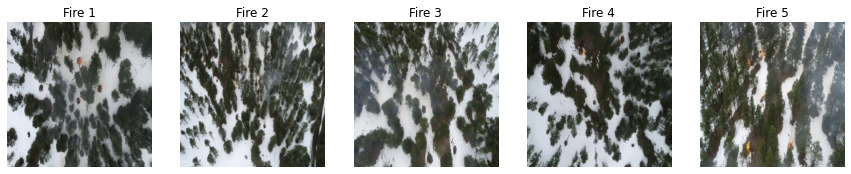

In [8]:
# Show 5 training fire images
show_random_images(train_fire_path, 'Fire')

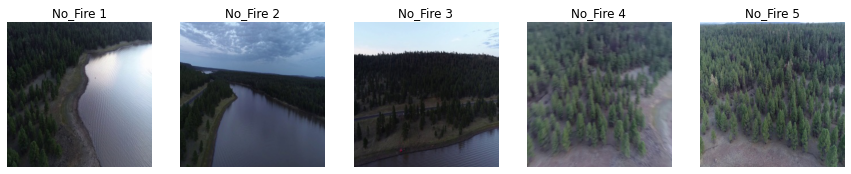

In [9]:
# Show 5 training nonfire images
show_random_images(train_nonfire_path, 'No_Fire')

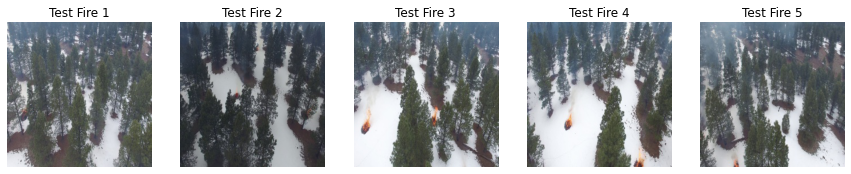

In [10]:
# Show 5 testing fire images
show_random_images(test_fire_path, 'Test Fire')

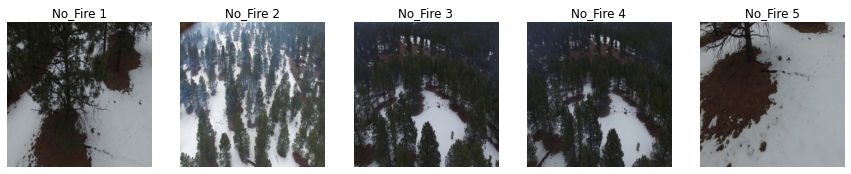

In [11]:
# Show 5 testing nonfire images
show_random_images(test_nonfire_path, 'No_Fire')

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For training - better augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,            # more random rotation
    width_shift_range=0.2,        # more horizontal shift
    height_shift_range=0.2,       # more vertical shift
    shear_range=0.2,              # add shear transformation
    zoom_range=0.3,               # more zoom
    brightness_range=[0.7, 1.3],  # random brightness
    horizontal_flip=True,
    fill_mode='nearest'           # fill missing pixels after transforms
)

# For testing - still only rescale
test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [13]:
# Data Generators
train_generator = train_datagen.flow_from_directory(
    'train_data/Training/',
    target_size=(254, 254),
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    'test_data/Test/',
    target_size=(254, 254),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [14]:
print(train_generator.class_indices)

{'Fire': 0, 'No_Fire': 1}


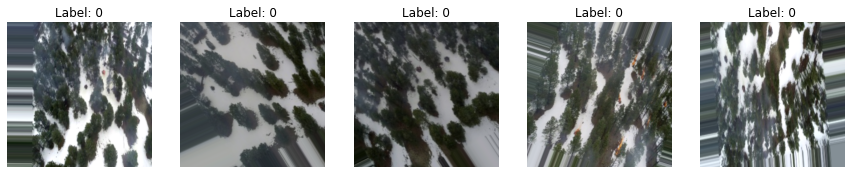

In [15]:
import matplotlib.pyplot as plt

# Get one batch from train_generator
images, labels = next(train_generator)

# Plot 5 images
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")  # 0 or 1
    plt.axis('off')
plt.show()

In [16]:
# Build the Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
# Load MobileNet with pre-trained weights
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(254, 254, 3))

# Updated: Unfreeze top 20 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 4s 0us/step


In [18]:
# Build the full model by adding custom layers on top of the base model
model = Sequential([
    base_model,                            # Add MobileNet base
    GlobalAveragePooling2D(),              # Pooling layer to reduce dimensions
    Dense(1, activation='sigmoid')         # Output layer for binary classification (Fire/No Fire)
])


In [19]:
# Updated: Compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
# Callbacks to save the best model and stop early if no improvement
checkpoint = ModelCheckpoint('best_mobilenet_model.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

In [21]:
# Updated: Train for 30 epochs
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 616 steps, validate for 135 steps
Epoch 1/20
615/616 [============================>.] - ETA: 2s - loss: 0.6928 - accuracy: 0.6354
Epoch 00001: val_loss improved from inf to 0.69262, saving model to best_mobilenet_model.h5
616/616 [==============================] - 1336s 2s/step - loss: 0.6928 - accuracy: 0.6354 - val_loss: 0.6926 - val_accuracy: 0.5961
Epoch 2/20
615/616 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.6354
Epoch 00002: val_loss improved from 0.69262 to 0.69210, saving model to best_mobilenet_model.h5
616/616 [==============================] - 464s 753ms/step - loss: 0.6920 - accuracy: 0.6354 - val_loss: 0.6921 - val_accuracy: 0.5961
Epoch 3/20
615/616 [============================>.] - ETA: 0s - loss: 0.6913 - accuracy: 0.6354
Epoch 00003: val_loss improved from 0.69210 to 0.69159, saving model to best_mobilenet_model.h5
616/616 [==============================] - 465s 755ms/step - loss:

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  MemoryError: Unable to allocate 47.3 MiB for an array with shape (64, 254, 254, 3) and data type float32
Traceback (most recent call last):

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 236, in __call__
    ret = func(*args)

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\tensorflow_core\python\data\ops\dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\tensorflow_core\python\keras\engine\data_adapter.py", line 975, in generator_fn
    yield x[i]

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\keras_preprocessing\image\iterator.py", line 222, in _get_batches_of_transformed_samples
    batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=self.dtype)

MemoryError: Unable to allocate 47.3 MiB for an array with shape (64, 254, 254, 3) and data type float32


	 [[{{node PyFunc}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_10]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  MemoryError: Unable to allocate 47.3 MiB for an array with shape (64, 254, 254, 3) and data type float32
Traceback (most recent call last):

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 236, in __call__
    ret = func(*args)

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\tensorflow_core\python\data\ops\dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\tensorflow_core\python\keras\engine\data_adapter.py", line 975, in generator_fn
    yield x[i]

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "c:\Users\Humayun\anaconda3\envs\ev_\lib\site-packages\keras_preprocessing\image\iterator.py", line 222, in _get_batches_of_transformed_samples
    batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=self.dtype)

MemoryError: Unable to allocate 47.3 MiB for an array with shape (64, 254, 254, 3) and data type float32


	 [[{{node PyFunc}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_7915]

Function call stack:
distributed_function -> distributed_function


In [22]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

  ...
    to  
  ['...']
135/135 [==============================] - 17s 129ms/step - loss: 0.6885 - accuracy: 0.5961
Test Loss: 0.6884992829075566
Test Accuracy: 0.5961471796035767


In [23]:
from tensorflow.keras.models import load_model

# 1. Load your saved .h5 model
loaded_mobilenet = load_model('best_mobilenet_model.h5')

# 2. Save it in the native Keras format
loaded_mobilenet.save('best_mobilenet_model.keras')

print("MobileNet model loaded from .h5 and saved as .keras ✅")

MobileNet model loaded from .h5 and saved as .keras ✅
